# **РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ**

## ***Факультет физико-математических и естественных наук***

## **Отчет по лабораторной работе "Нелинейная регрессия"**

---



### **Студент** : Озьяс Стев Икнэль Дани   ------  **Группа** : НКНбд-01-21



**Вариант 26**

1. Набор данных dtd с изменением разрешения до 60x90

2. Классы с метками 26,27,28,30

3. Требования к архитектуре сети MLP:

- Функциональный API при создании

- Функция потерь: разреженная категориальная кросс-энтропия

- Кол-во скрытых слоев 6

- Кол-во нейронов 40 в каждом нечетном скрытом слое, 60 в каждом четном скрытом слое

- Использование слоев dropout

4. Требования к архитектуре сети CNN:

- Последовательный API со списком слоев при создании

- Функция потерь: категориальная кросс-энтропия

- Кол-во слоев пулинга 2

- Количество фильтров в сверточных слоях 16

- Размеры фильтра 4х4

- Использование слоев с регуляризацией L2

5. Требования к архитектуре сети RNN:

- Последовательный API с методом add() при создании

- Функция потерь: разреженная категориальная кросс-энтропия

- Слой LSTM с 64 нейронами

- Использование слоев пакетной нормализации

6. Показатель качества многоклассовой классификации:

средняя точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.



In [ ]:
# Добавляем библиотеки, которыми мы воспользуемся в дальнейшем:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageOps
from keras import regularizers
from sklearn.model_selection import train_test_split

## **Задание 1**

Считаем из tensorflow набор данных **dtd**:

(300, 400, 3)
(90, 60, 3)


((1880, 3), (940, 3), (940, 3))

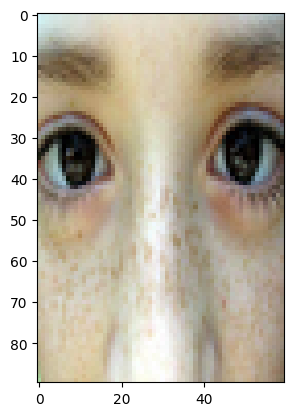

In [ ]:
ds = tfds.load("dtd", split=['train', 'test'])

#Сначала разбиение на обучающую и тестовую выборки

df_train = tfds.as_dataframe(ds[0])
df_test = tfds.as_dataframe(ds[1])

print(df_train.iloc[0]['image'].shape)

#изменение разрешения до 60x90
df_train_resized = []
df_test_resized = []

for i in range(len(df_train)):
  img = Image.fromarray(df_train.iloc[i]['image'])
  img = img.resize((60,90),Image.Resampling.LANCZOS)
  df_train_resized.append(np.array(img))

df_train['image'] = df_train_resized

for i in range(len(df_test)):
  img = Image.fromarray(df_test.iloc[i]['image'])
  img = img.resize((60,90),Image.Resampling.LANCZOS)
  df_test_resized.append(np.array(img))

df_test['image'] = df_test_resized

# размер после изменения
print(df_train.iloc[0]['image'].shape)
plt.imshow(Image.fromarray(df_train.iloc[0]['image']));

#Теперь разбиение на обучающую, валидационную и тестовую выборки
# Обучающий набор имеет размер размер 0,5 от исходного набора dtd
# И тестовый набор и валидационный набор имеют одинаковый размер - 0,25 от исходного набора dtd

test_size= int(0.5* len(df_test))
df_test, df_val = df_test[:test_size], df_test[test_size:]

df_train.shape, df_test.shape, df_val.shape

## **Задача 2**

Оставим в наборе изображения 4 классов **с метками 26, 27, 28, 30**

In [ ]:
df_train2 = pd.DataFrame()
df_test2 = pd.DataFrame()
df_val2 = pd.DataFrame()

selected_classes=[26, 27, 28, 30]

df_train2 = df_train.loc[df_train['label'].isin(selected_classes)]
df_test2 = df_test.loc[df_test['label'].isin(selected_classes)]
df_val2 = df_val.loc[df_val['label'].isin(selected_classes)]

df_train2.shape, df_test2.shape, df_val2.shape

((160, 3), (74, 3), (86, 3))

Здесь очевидно что у нас теперь толкьо 4 класса

In [ ]:
df_train2['label'].value_counts()

label
30    40
28    40
27    40
26    40
Name: count, dtype: int64

### Визуализация нескольких рандомных изображений из тестовой выборки после сокращения набора до 4 классов.

Используем сокращенный набор для этого

In [ ]:
import random

def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)

    num_row = 2
    num_col = 5

    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i]
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

In [ ]:
train_labels2 = df_train2['label'].to_numpy(dtype=np.float32)
test_labels2 = df_test2['label'].to_numpy(dtype=np.float32)
val_labels2 = df_val2['label'].to_numpy(dtype=np.float32)
train_labels2.shape, test_labels2.shape, val_labels2.shape

((160,), (74,), (86,))

In [ ]:
train_images2 = np.zeros(shape=(df_train2.shape[0],90,60,3), dtype=np.float32)
test_images2  = np.zeros(shape=(df_test2.shape[0],90,60,3), dtype=np.float32)
val_images2 = np.zeros(shape=(df_val2.shape[0],90,60,3), dtype=np.float32)

train_images2.shape, test_images2.shape, val_images2.shape

((160, 90, 60, 3), (74, 90, 60, 3), (86, 90, 60, 3))

In [ ]:
for idx in range(train_labels2.shape[0]):
    train_images2[idx,:,:,:] = \
        np.array(Image.fromarray(df_train2.iloc[idx]['image']))

for idx in range(test_labels2.shape[0]):
    test_images2[idx,:,:,:] = \
        np.array(Image.fromarray(df_test2.iloc[idx]['image']))

for idx in range(val_labels2.shape[0]):
    val_images2[idx,:,:,:] = \
        np.array(Image.fromarray(df_val2.iloc[idx]['image']))

train_images2.shape, test_images2.shape, val_images2.shape

((160, 90, 60, 3), (74, 90, 60, 3), (86, 90, 60, 3))

In [ ]:
train_images2 /= 255
test_images2  /= 255
val_images2 /= 255

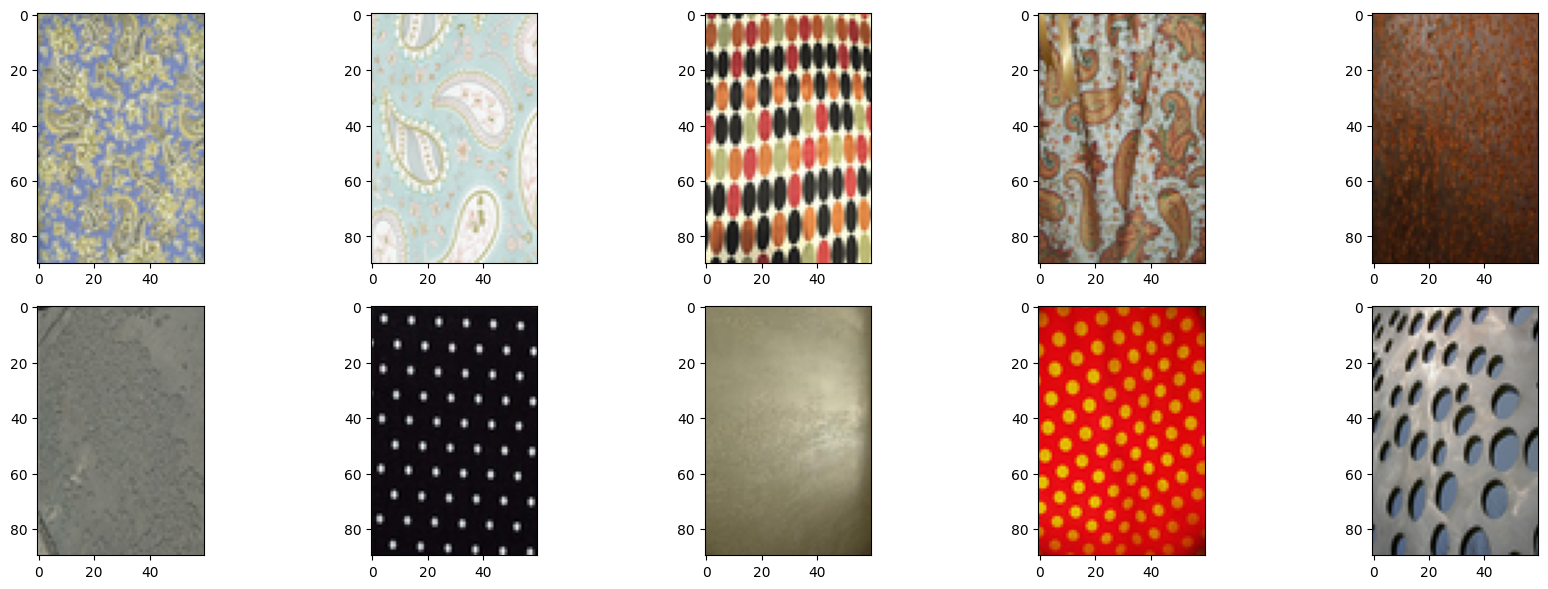

In [ ]:
plot_random_sample(test_images2)

## **Задача 3**

### Создание нейронной сети MLP (Functional API)

Сначала создаем входные данные нейронной сети:

In [ ]:
inputs = tf.keras.layers.Input(shape=(90, 60, 3))

Здесь указывается размерность данных, при этом количество данных всегда опускается. Переменная `inputs` содержит информацию о размерах и типе данных которые будут передаваться в модель:

In [ ]:
inputs.shape, inputs.dtype

(TensorShape([None, 90, 60, 3]), tf.float32)

In [ ]:
x = tf.keras.layers.Flatten()(inputs)

Добавим наши 6 скрытых слоев в граф слоев:

In [ ]:
x = tf.keras.layers.Dense(40, kernel_initializer='lecun_normal', activation='selu', name='HiddenLayer1')(x)
x = tf.keras.layers.Dense(60, kernel_initializer='lecun_normal', activation='selu', name='HiddenLayer2')(x)
x = tf.keras.layers.Dense(40, kernel_initializer='lecun_normal', activation='selu', name='HiddenLayer3')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(60, kernel_initializer='lecun_normal', activation='selu', name='HiddenLayer4')(x)
x = tf.keras.layers.Dense(40, kernel_initializer='lecun_normal', activation='selu', name='HiddenLayer5')(x)
x = tf.keras.layers.Dense(60, kernel_initializer='lecun_normal', activation='selu', name='HiddenLayer6')(x)

Наконец, добавим последний выходной слой:

In [ ]:
outputs = tf.keras.layers.Dense(47, activation='softmax', name='OutputLayer')(x)

Теперь создаем модель, указав ее входы и выходы в графе слоев:

In [ ]:
model_MLP = tf.keras.Model(inputs=inputs, outputs=outputs)
model_MLP.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 60, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 16200)             0         
                                                                 
 HiddenLayer1 (Dense)        (None, 40)                648040    
                                                                 
 HiddenLayer2 (Dense)        (None, 60)                2460      
                                                                 
 HiddenLayer3 (Dense)        (None, 40)                2440      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 HiddenLayer4 (Dense)        (None, 60)                2460  

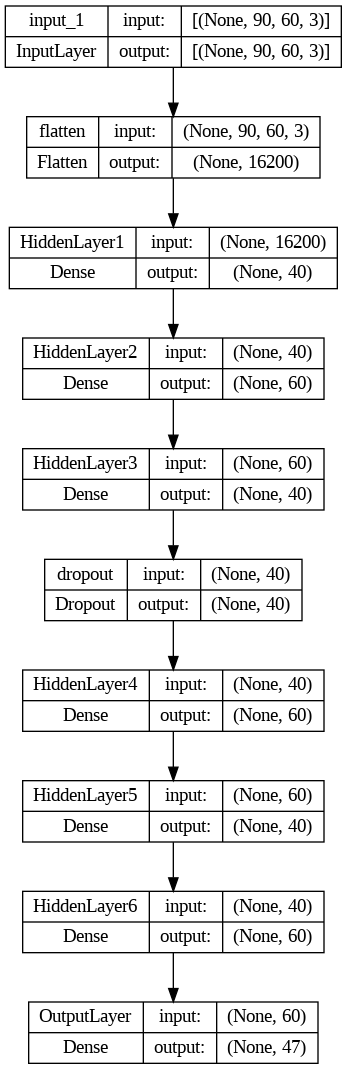

In [ ]:
tf.keras.utils.plot_model(model_MLP, show_shapes=True)

In [ ]:
model_MLP.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="sgd",
    metrics=["accuracy"],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_1 = model_MLP.fit(
    train_images2,
    train_labels2,
    epochs=100,
    batch_size=47, #labels от 0 до 46
    validation_data=(val_images2, val_labels2),
    callbacks=[callback]
)

Epoch 1/100
4/4 [==============================] - 1s 113ms/step - loss: 3.6174 - accuracy: 0.0750 - val_loss: 1.9401 - val_accuracy: 0.1744
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 2.2765 - accuracy: 0.2062 - val_loss: 2.2649 - val_accuracy: 0.1860
Epoch 3/100
4/4 [==============================] - 0s 24ms/step - loss: 1.8165 - accuracy: 0.3187 - val_loss: 1.6777 - val_accuracy: 0.2558
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 1.7229 - accuracy: 0.2625 - val_loss: 1.9450 - val_accuracy: 0.1395
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 1.8313 - accuracy: 0.2000 - val_loss: 1.5696 - val_accuracy: 0.1512
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 1.6150 - accuracy: 0.2188 - val_loss: 1.7998 - val_accuracy: 0.2791
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 1.6443 - accuracy: 0.2438 - val_loss: 1.5926 - val_accuracy: 0.1395
Epoch 8/100
4/4 [==

In [ ]:
print("Количество потребовавшихся эпох обучения для сети MLP = ", len(history_1.history['loss']))

Количество потребовавшихся эпох обучения для сети MLP =  26


### Создание нейронной сети CNN (Sequential API)

In [ ]:
tf.random.set_seed(42)

model_CNN = tf.keras.Sequential([tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), input_shape=(90, 60, 3), activation='elu')])

model_CNN.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), padding='same'))
model_CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='elu'))
model_CNN.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), padding='same'))
model_CNN.add(tf.keras.layers.Flatten())
model_CNN.add(tf.keras.layers.Dropout(rate=0.3))
model_CNN.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.01)),)
model_CNN.add(tf.keras.layers.Dense(47, activation='softmax'))

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 60, 16)        64        
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 15, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 13, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dropout_1 (Dropout)         (None, 384)               0

In [ ]:
train_labelsCnn = tf.keras.utils.to_categorical(train_labels2, num_classes=47)
val_labelsCnn = tf.keras.utils.to_categorical(val_labels2, num_classes=47)
train_labelsCnn.shape, val_labelsCnn.shape

((160, 47), (86, 47))

In [ ]:
model_CNN.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_2 = model_CNN.fit(
    train_images2,
    train_labelsCnn,
    epochs=100,
    batch_size=47,
    validation_data=(val_images2, val_labelsCnn),
    callbacks=[callback]
)

Epoch 1/100
4/4 [==============================] - 1s 168ms/step - loss: 5.8991 - accuracy: 0.9787 - val_loss: 5.7085 - val_accuracy: 0.9787
Epoch 2/100
4/4 [==============================] - 0s 94ms/step - loss: 5.6699 - accuracy: 0.9787 - val_loss: 5.5048 - val_accuracy: 0.9787
Epoch 3/100
4/4 [==============================] - 1s 138ms/step - loss: 5.4572 - accuracy: 0.9787 - val_loss: 5.2618 - val_accuracy: 0.9787
Epoch 4/100
4/4 [==============================] - 0s 121ms/step - loss: 5.2092 - accuracy: 0.9787 - val_loss: 4.9408 - val_accuracy: 0.9787
Epoch 5/100
4/4 [==============================] - 0s 124ms/step - loss: 4.8605 - accuracy: 0.9787 - val_loss: 4.5017 - val_accuracy: 0.9787
Epoch 6/100
4/4 [==============================] - 0s 129ms/step - loss: 4.4151 - accuracy: 0.9787 - val_loss: 4.0302 - val_accuracy: 0.9787
Epoch 7/100
4/4 [==============================] - 0s 124ms/step - loss: 3.9733 - accuracy: 0.9787 - val_loss: 3.7109 - val_accuracy: 0.9787
Epoch 8/100
4/

In [ ]:
print("Количество потребовавшихся эпох обучения для сети CNN = ", len(history_2.history['loss']))

Количество потребовавшихся эпох обучения для сети CNN =  48


### Создание нейронной сети RNN

Создаем модель со слоем LSTM:

In [ ]:
model_RNN = tf.keras.Sequential([
  tf.keras.layers.LSTM(64, input_shape=(270, 60))
])
model_RNN.add(tf.keras.layers.BatchNormalization())
model_RNN.add(tf.keras.layers.Dense(47, activation='softmax'))

model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                32000     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 47)                3055      
                                                                 
Total params: 35311 (137.93 KB)
Trainable params: 35183 (137.43 KB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________


In [ ]:
model_RNN.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="sgd",
    metrics=["accuracy"],
)

In [ ]:
m1,n1 = train_images2.shape[::2]
train_imagesRnn = np.rollaxis(train_images2,3,1).reshape(m1,-1,n1)

m2,n2 = val_images2.shape[::2]
val_imagesRnn = np.rollaxis(val_images2,3,1).reshape(m2,-1,n2)
train_imagesRnn.shape, val_imagesRnn.shape

((160, 270, 60), (86, 270, 60))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_3 = model_RNN.fit(
    train_imagesRnn,
    train_labels2,
    epochs=200,
    batch_size=64,
    validation_data=(val_imagesRnn, val_labels2),
    callbacks=[callback]
)

Epoch 1/200
3/3 [==============================] - 4s 465ms/step - loss: 4.3287 - accuracy: 0.0188 - val_loss: 3.9248 - val_accuracy: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 1s 202ms/step - loss: 4.2013 - accuracy: 0.0125 - val_loss: 3.9138 - val_accuracy: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 0s 178ms/step - loss: 4.0849 - accuracy: 0.0188 - val_loss: 3.9053 - val_accuracy: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 1s 198ms/step - loss: 4.0072 - accuracy: 0.0188 - val_loss: 3.8914 - val_accuracy: 0.0000e+00
Epoch 5/200
3/3 [==============================] - 1s 202ms/step - loss: 3.9214 - accuracy: 0.0125 - val_loss: 3.8795 - val_accuracy: 0.0000e+00
Epoch 6/200
3/3 [==============================] - 0s 171ms/step - loss: 3.8429 - accuracy: 0.0375 - val_loss: 3.8673 - val_accuracy: 0.0116
Epoch 7/200
3/3 [==============================] - 0s 170ms/step - loss: 3.7776 - accuracy: 0.0625 - val_loss: 3.8541 - val_accuracy: 

In [ ]:
print("Количество потребовавшихся эпох обучения для сети RNN = ", len(history_3.history['loss']))

Количество потребовавшихся эпох обучения для сети RNN =  110


## **Задача 4**

Оценим качество многоклассовой классификации нейронными сетями MLP, CNN и RNN на тестовой выборке при помощи показателя качества: **средняя точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.**

In [ ]:
def TN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 0))

In [ ]:
def FP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 1))

In [ ]:
def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 0))

In [ ]:
def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 1))

Показатель качества многоклассовой классификации **Средняя точность классов**

**Precision** = $\frac{TP}{TP + FP}$

In [ ]:
def Score(y_true, y_predict):
  if((TP(y_true, y_predict) + FP(y_true, y_predict))) == 0:
    return 0
  return TP(y_true, y_predict)/(TP(y_true, y_predict) + FP(y_true, y_predict))

In [ ]:
m1,n1 = test_images2.shape[::2]
test_imagesRnn = np.rollaxis(test_images2,3,1).reshape(m1,-1,n1)

In [ ]:
pred1_labels2 = model_MLP.predict(test_images2)
pred2_labels2 = model_CNN.predict(test_images2)
pred3_labels2 = model_RNN.predict(test_imagesRnn)

pred1 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred1_labels2)])
pred2 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred2_labels2)])
pred3 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred3_labels2)])

pred1.size, pred2.shape, pred3.shape,

3/3 [==============================] - 1s 29ms/step


(3478, (3478,), (3478,))

In [ ]:
pred1 = np.reshape(pred1, (47, 74))
pred2 = np.reshape(pred2, (47, 74))
pred3 = np.reshape(pred3, (47, 74))

pred1.shape, pred2.shape, pred3.shape

((47, 74), (47, 74), (47, 74))

In [ ]:
score1 =  0
score2 =  0
score3 =  0

for i in range(47):
  score1 += Score(test_labels2, pred1[i])
  score2 = score2 + Score(test_labels2, pred2[i])
  score3 = score3 + Score(test_labels2, pred3[i])

score1 /= 47
score2 /= 47
score3 /= 47

In [ ]:
print("Качество нейронной сети MLP = ", score1)
print("Качество нейронной сети CNN = ", score2)
print("Качество нейронной сети RNN = ", score3)

Качество нейронной сети MLP =  0.0
Качество нейронной сети CNN =  0.0
Качество нейронной сети RNN =  0.0


### Кривые обучения




## **Задача 5**

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [ ]:
minepochs = min(len(history_1.history['loss']), len(history_2.history['loss']))
minepochs = min(minepochs, len(history_3.history['loss']))
minepochs

26

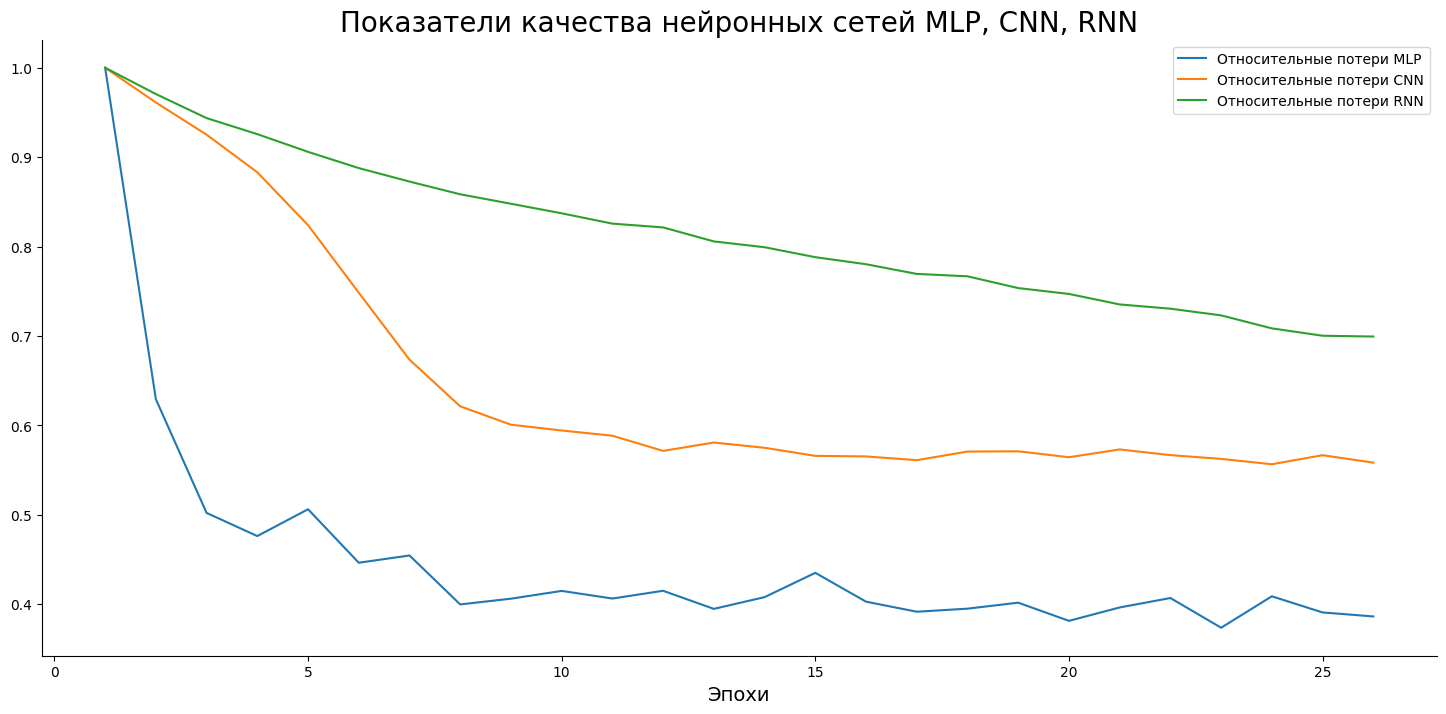

In [ ]:
plt.plot(np.arange(1, minepochs+1), np.array(history_1.history['loss'][:minepochs])/history_1.history['loss'][0], label='Относительные потери MLP')
plt.plot(np.arange(1, minepochs+1), np.array(history_2.history['loss'][:minepochs])/history_2.history['loss'][0], label='Относительные потери CNN')
plt.plot(np.arange(1, minepochs+1), np.array(history_3.history['loss'][:minepochs])/history_3.history['loss'][0], label='Относительные потери RNN')
plt.title('Показатели качества нейронных сетей MLP, CNN, RNN', size=20)
plt.xlabel('Эпохи', size=14)
plt.legend();

## **Задача 6**

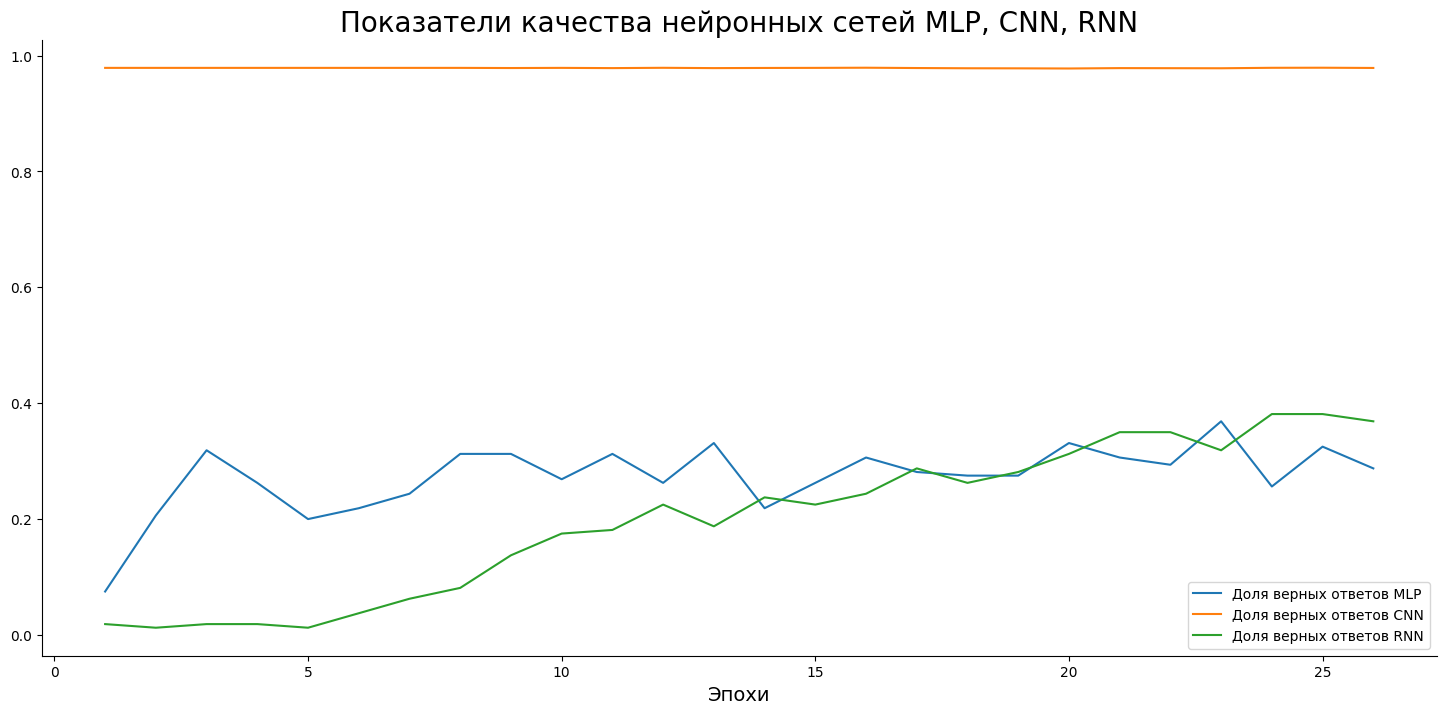

In [ ]:
plt.plot(np.arange(1, minepochs+1), history_1.history['accuracy'][:minepochs], label='Доля верных ответов MLP')
plt.plot(np.arange(1, minepochs+1), history_2.history['accuracy'][:minepochs], label='Доля верных ответов CNN')
plt.plot(np.arange(1, minepochs+1), history_3.history['accuracy'][:minepochs], label='Доля верных ответов RNN')
plt.title('Показатели качества нейронных сетей MLP, CNN, RNN', size=20)
plt.xlabel('Эпохи', size=14)
plt.legend();

Судя по оценкам качества и кривым обучения сетей, лучшая сеть есть **модель СИИ**.
Его архитектура выглядит так:

In [ ]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 60, 16)        64        
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 15, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 13, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dropout_1 (Dropout)         (None, 384)               0

## **Задача 7**

Для каждого из 4 классов определим два изображения в тестовой выборке, имеющее минимальную и максимальную вероятности классификации в правильный класс, и визуализируем эти изображения.

In [ ]:
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1)
    ax[1].imshow(img2);

3/3 [==============================] - 0s 9ms/step


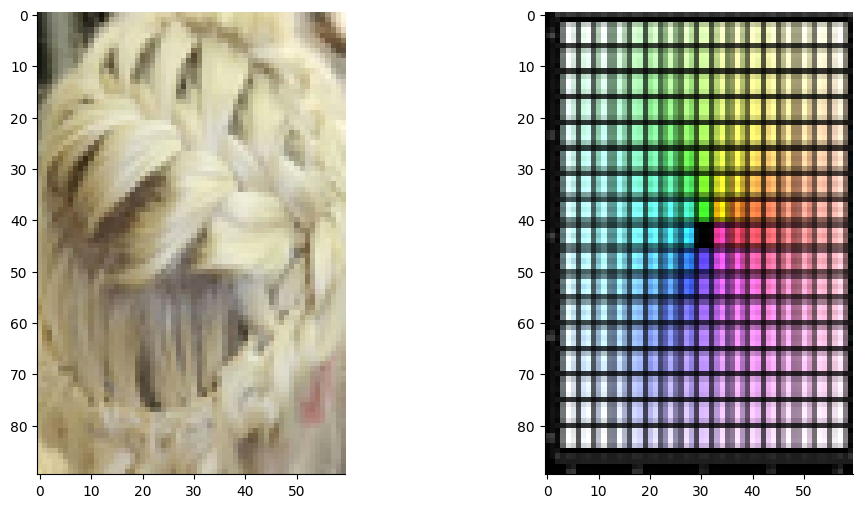

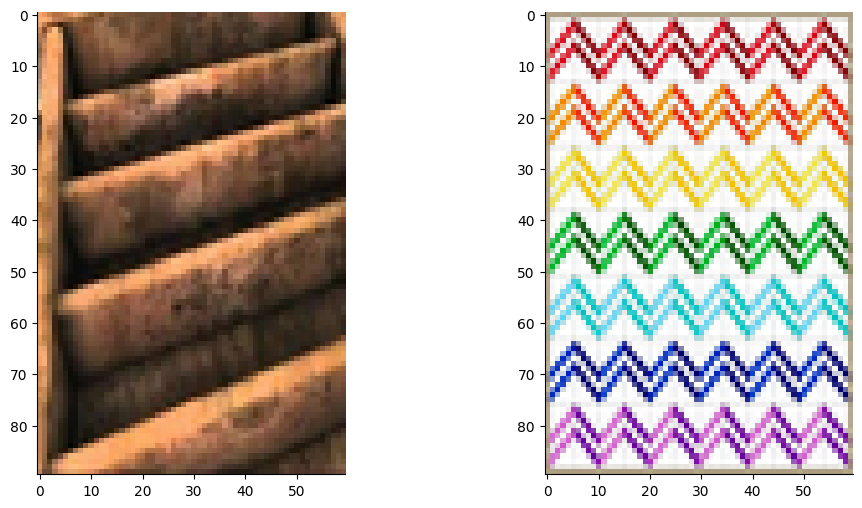

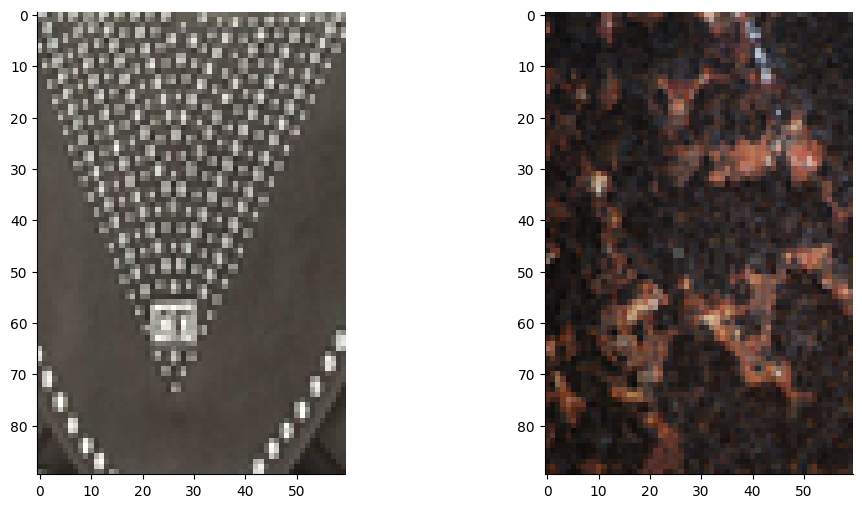

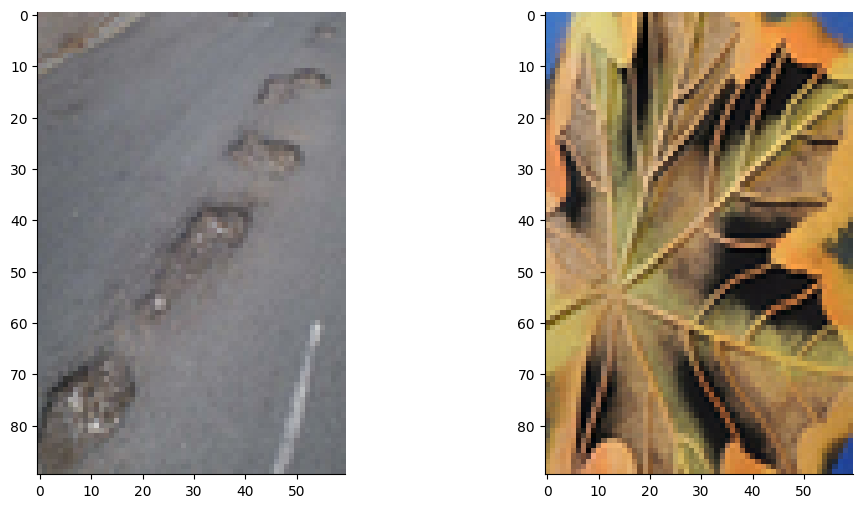

In [ ]:
test = pd.DataFrame()
pred = model_CNN.predict(test_images2)
pred = np.reshape(pred, (47, 74))

imin = []
imax = []

i = 0
for cl in selected_classes:
  imin.append(np.argmin(pred[cl]))
  imax.append(np.argmax(pred[cl]))
  plot_two_images(Image.fromarray(df_train.iloc[imin[i]]['image']), Image.fromarray(df_train.iloc[imax[i]]['image']))
  i += 1
